Default parameters:  mask- 0.25  circle mode- no


/home/pavel/anaconda3/lib/python3.6/site-packages/statsmodels/robust/robust_linear_model.py:278: RuntimeWarning: divide by zero encountered in true_divide
  self.weights = self.M.weights(wls_results.resid/self.scale)
/home/pavel/anaconda3/lib/python3.6/site-packages/statsmodels/robust/robust_linear_model.py:278: RuntimeWarning: invalid value encountered in true_divide
  self.weights = self.M.weights(wls_results.resid/self.scale)
/home/pavel/anaconda3/lib/python3.6/site-packages/statsmodels/robust/norms.py:190: RuntimeWarning: invalid value encountered in less_equal
  return np.less_equal(np.fabs(z), self.t)
/home/pavel/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1728: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
/home/pavel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/pavel/anaconda3/lib/python3.6/site-packages/statsmodels/robust/norm

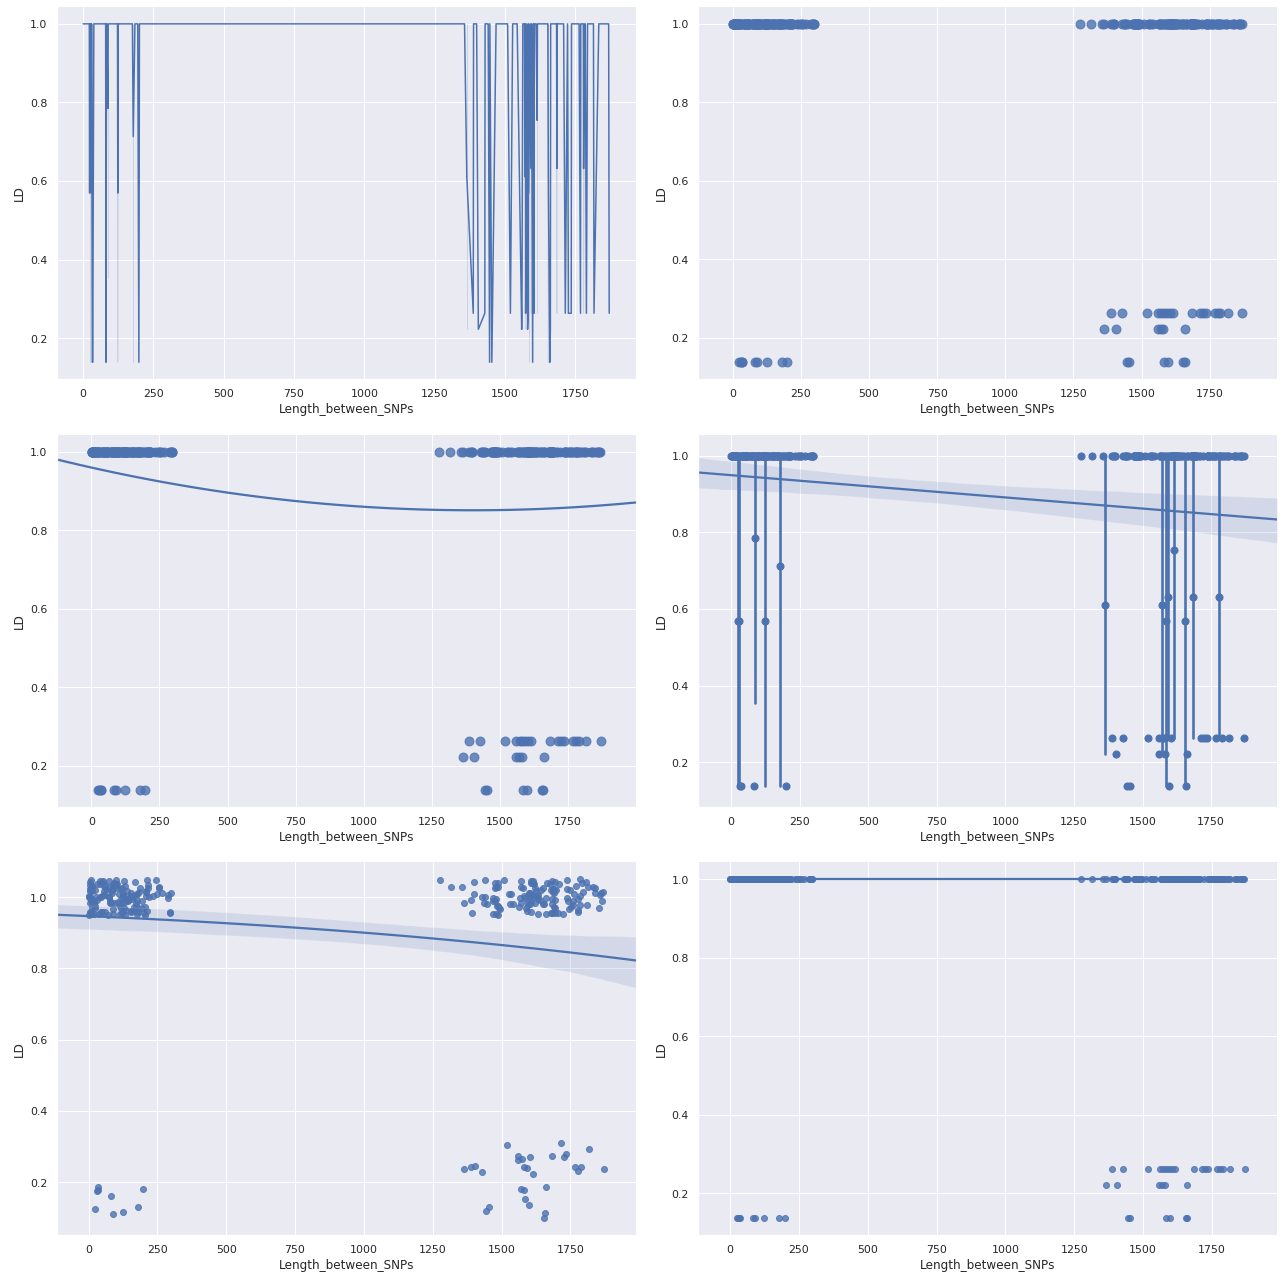

Done


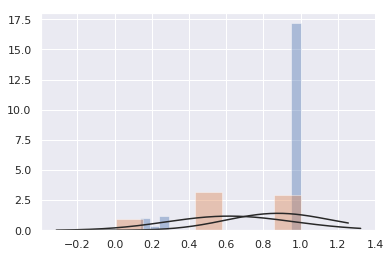

In [10]:

# coding: utf-8

# In[206]:


# --------------Biblio & modules-------------------------------------
import sys
from sys import argv
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from time import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from scipy import stats


# ---------------------------------Extracting file-----------------------------
if len(sys.argv) == 1:  # input control
    print("Invalid arguments")
    sys.exit(1)

#in_file = open(argv[1], "r")   # It must be a alignment with equal lengths of sequences
#print("Starting LD calculation of ", argv[1])

in_file = open("Bivalvia_control.fasta.aligned.fasta", "r")   # It must be a alignment with equal lengths of sequences

# -------------------------------Modules-----------------------------------------
round_ = 4  # The round parameter!
h = 0.25 #float(argv[3])  # The mask parameter!
is_circle = "no"  # circle mode 
print("Default parameters: ", "mask-", h, " circle mode-", is_circle)


def slice_module(slice_number, align_slice):   # It takes a slice bar os sequences and write in to the out_file
    align_slice = align_slice.upper()
    A = align_slice.count("A")
    T = align_slice.count("T")
    G = align_slice.count("G")
    C = align_slice.count("C")
    counter_A_pr = round(float(align_slice.count("A") / len(align_slice)), round_)
    counter_T_pr = round(float(align_slice.count("T") / len(align_slice)), round_)
    counter_G_pr = round(float(align_slice.count("G") / len(align_slice)), round_)
    counter_C_pr = round(float(align_slice.count("C") / len(align_slice)), round_)
    counter_N_pr = round(float(align_slice.count("N") / len(align_slice)), round_)
    counter__pr = round(float(align_slice.count("-") / len(align_slice)), round_)
    if ((counter_A_pr or counter_T_pr or counter_G_pr or counter_C_pr or counter_N_pr or counter__pr) == 1) or (counter_N_pr or counter__pr != 0):
        return 0
    else:
        if A+T == len(align_slice) or A+G == len(align_slice) or A+C == len(align_slice) or T+G == len(align_slice) or T+C == len(align_slice) or G+C == len(align_slice):
            if min(counter_A_pr, counter_T_pr) > h or min(counter_A_pr, counter_G_pr) > h or min(counter_A_pr, counter_C_pr) > h or min(counter_T_pr, counter_G_pr) > h or min(counter_T_pr, counter_C_pr) > h or min(counter_G_pr, counter_C_pr) > h:
                slice_id_dic[slice_number] = align_slice  # Making a dict with seqs and keys
        return 1


def nuc_identification_module(line):  # Looking for nuc and nuc% in line
    array = list(line)
    result = {i: array.count(i) for i in array};
    return result


def duplet_compute_module(duplet_list, A, B):
    A_keys = []
    B_keys = []
    for key in A.keys():
        A_keys = A_keys + [key]
    for key in B.keys():
        B_keys = B_keys + [key]

    p1 = round(A[A_keys[0]]/(A[A_keys[0]] + A[A_keys[1]]), round_)
    p2 = round(A[A_keys[1]]/(A[A_keys[0]] + A[A_keys[1]]), round_)
    q1 = round(B[B_keys[0]]/(B[B_keys[0]] + B[B_keys[1]]), round_)
    q2 = round(B[B_keys[1]]/(B[B_keys[0]] + B[B_keys[1]]), round_)

    p1q1 = str(A_keys[0]) + str(B_keys[0])
    p1q2 = str(A_keys[0]) + str(B_keys[1])
    p2q1 = str(A_keys[1]) + str(B_keys[0])
    p2q2 = str(A_keys[1]) + str(B_keys[1])

    counter_p1q1_pr = round(float(duplet_list.count(p1q1) / len(duplet_list)), round_)
    counter_p1q2_pr = round(float(duplet_list.count(p1q2) / len(duplet_list)), round_)
    counter_p2q1_pr = round(float(duplet_list.count(p2q1) / len(duplet_list)), round_)
    counter_p2q2_pr = round(float(duplet_list.count(p2q2) / len(duplet_list)), round_)
    return counter_p1q1_pr, counter_p1q2_pr, counter_p2q1_pr, counter_p2q2_pr, p1, p2, q1, q2


class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or             isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


# -------------------------LD calculation---------------------------
        
        
alignment = AlignIO.read(in_file, "fasta")  # Importing all alignments from in file
in_file.close()


align_slice = ''
slice_id_dic = {}

genome_size = len(alignment[0, :])
for slice_number in range(genome_size):  # Taking a nucleotide from each bar/slice in alignment and from each sequence. For nuc in range of length of seq
    for seq in range(len(alignment)):  # For seq from all seqs
        align_slice = align_slice + str(alignment[seq, slice_number])  # Making slices
    a = slice_module(slice_number, align_slice)  # Collecting it and putting in the slice_module
    align_slice = ''                    
    

    
#LD_out_file = open("LD.txt", "w")
#LD_out_file.write("Len" + "\t" + "LD" + "\n")

#r2_out_file = open("r2.txt", "w")
#r2_out_file.write("Len" + "\t" + "r2" + "\n")


Len_list = []
LD_list = []
r2_list = []
for key in list(slice_id_dic):  # For keys in dict
    one = slice_id_dic[key]  # Retrieving a slice
    for q in list(slice_id_dic):
        if key < q:  # if we want to count for a half
            if is_circle == "yes":
                summ = min(abs(int(q) - int(key)), genome_size - abs(int(key) - int(q)))  # Calculating the distance
            if is_circle == "no":
                summ = abs(int(q) - int(key))
            two = slice_id_dic[q]
            line1 = one.strip()
            line2 = two.strip()
            A = nuc_identification_module(line1)
            B = nuc_identification_module(line2)

            duplet_list = []
            for i in range(len(line1)):
                duplet_list = duplet_list + [line1[i] + line2[i]]
            AB = duplet_compute_module(duplet_list, A, B)
            LD = AB[0]*AB[3] - AB[1]*AB[2]    # D and LD formula
            if LD >= 0:
                LD_out = round(LD/(min(AB[4]*AB[7], AB[5]*AB[6])), round_)
            if LD < 0:
                LD_out = round(LD/(max(-AB[4]*AB[6], -AB[5]*AB[7])), round_)

            #LD_out_file.write(str(summ) + "\t" + str(LD_out) + "\n")

            r = round((LD**2)/(AB[4]*AB[5]*AB[6]*AB[7]), round_)
            #r2_out_file.write(str(summ) + "\t" + str(r) + "\n")
            Len_list.append(summ)
            LD_list.append(LD_out)
            r2_list.append(r)
            
#LD_out_file.close() 
#r2_out_file.close() 


# -------------------------Visualization---------------------------
df = pd.DataFrame(dict(Length_between_SNPs=np.array(Len_list), LD=np.array(LD_list), R2=np.array(r2_list)))


# simpe plot
g0 = sns.relplot(x="Length_between_SNPs", y="LD", kind="line", data=df)

# robust line
g1 = sns.lmplot(x="Length_between_SNPs", y="LD", data=df,
          robust=True, ci=None, scatter_kws={"s": 80});

#polynomial 
g2 = sns.lmplot(x="Length_between_SNPs", y="LD", data=df,
           order=2, ci=None, scatter_kws={"s": 80});

# plot with confidence interval
g3 = sns.lmplot(x="Length_between_SNPs", y="LD", data=df, x_estimator=np.mean);

# logistic regression
g4 = sns.lmplot(x="Length_between_SNPs", y="LD", data=df,
           logistic=True, y_jitter=.05);

#  lowess smoother
g5 = sns.lmplot(x="Length_between_SNPs", y="LD", data=df,
           lowess=True);


fig = plt.figure(figsize=(18,18))
gs = gridspec.GridSpec(3, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[2])
mg3 = SeabornFig2Grid(g3, fig, gs[3])
mg4 = SeabornFig2Grid(g4, fig, gs[4])
mg5 = SeabornFig2Grid(g5, fig, gs[5])

gs.tight_layout(fig)



plt.show()

#fig.savefig(str(argv[2]) + ".png") 

plot2 = sns.distplot(np.array(LD_list), kde=False, fit=stats.gamma);
plot2 = sns.distplot(np.array(r2_list), kde=False, fit=stats.gamma);
fig2 = plot2.get_figure()
fig2.savefig("out_dist.png")
#fig.savefig(str(argv[2]) + "_dist.png") 
print("Done")

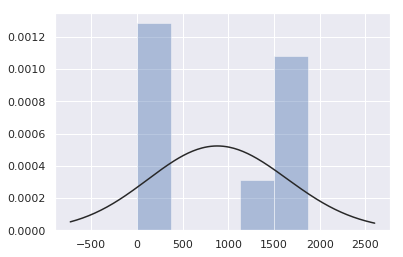

In [52]:
sns.distplot(np.array(Len_list), kde=False, fit=stats.gamma);

Default parameters:  mask- 0.25  circle mode- no
Done


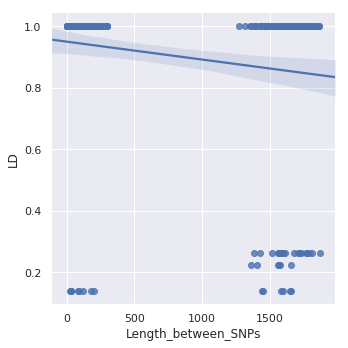

In [7]:

# coding: utf-8

# In[206]:


# --------------Biblio & modules-------------------------------------
import sys
from sys import argv
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from time import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()


# ---------------------------------Extracting file-----------------------------
if len(sys.argv) == 1:  # input control
    print("Invalid arguments")
    sys.exit(1)

#in_file = open(argv[1], "r")   # It must be a alignment with equal lengths of sequences
#print("Starting LD calculation of ", argv[1])

in_file = open("/home/pavel/Desktop/Work/Project/plotter/Bivalvia_control.fasta.aligned.fasta", "r")   # It must be a alignment with equal lengths of sequences

# -------------------------------Modules-----------------------------------------
round_ = 4  # The round parameter!
h = 0.25 #float(argv[3])  # The mask parameter!
is_circle = "no"  # circle mode 
print("Default parameters: ", "mask-", h, " circle mode-", is_circle)


def slice_module(slice_number, align_slice):   # It takes a slice bar os sequences and write in to the out_file
    align_slice = align_slice.upper()
    A = align_slice.count("A")
    T = align_slice.count("T")
    G = align_slice.count("G")
    C = align_slice.count("C")
    counter_A_pr = round(float(align_slice.count("A") / len(align_slice)), round_)
    counter_T_pr = round(float(align_slice.count("T") / len(align_slice)), round_)
    counter_G_pr = round(float(align_slice.count("G") / len(align_slice)), round_)
    counter_C_pr = round(float(align_slice.count("C") / len(align_slice)), round_)
    counter_N_pr = round(float(align_slice.count("N") / len(align_slice)), round_)
    counter__pr = round(float(align_slice.count("-") / len(align_slice)), round_)
    if ((counter_A_pr or counter_T_pr or counter_G_pr or counter_C_pr or counter_N_pr or counter__pr) == 1) or (counter_N_pr or counter__pr != 0):
        return 0
    else:
        if A+T == len(align_slice) or A+G == len(align_slice) or A+C == len(align_slice) or T+G == len(align_slice) or T+C == len(align_slice) or G+C == len(align_slice):
            if min(counter_A_pr, counter_T_pr) > h or min(counter_A_pr, counter_G_pr) > h or min(counter_A_pr, counter_C_pr) > h or min(counter_T_pr, counter_G_pr) > h or min(counter_T_pr, counter_C_pr) > h or min(counter_G_pr, counter_C_pr) > h:
                slice_id_dic[slice_number] = align_slice  # Making a dict with seqs and keys
        return 1


def nuc_identification_module(line):  # Looking for nuc and nuc% in line
    array = list(line)
    result = {i: array.count(i) for i in array};
    return result


def duplet_compute_module(duplet_list, A, B):
    A_keys = []
    B_keys = []
    for key in A.keys():
        A_keys = A_keys + [key]
    for key in B.keys():
        B_keys = B_keys + [key]

    p1 = round(A[A_keys[0]]/(A[A_keys[0]] + A[A_keys[1]]), round_)
    p2 = round(A[A_keys[1]]/(A[A_keys[0]] + A[A_keys[1]]), round_)
    q1 = round(B[B_keys[0]]/(B[B_keys[0]] + B[B_keys[1]]), round_)
    q2 = round(B[B_keys[1]]/(B[B_keys[0]] + B[B_keys[1]]), round_)

    p1q1 = str(A_keys[0]) + str(B_keys[0])
    p1q2 = str(A_keys[0]) + str(B_keys[1])
    p2q1 = str(A_keys[1]) + str(B_keys[0])
    p2q2 = str(A_keys[1]) + str(B_keys[1])

    counter_p1q1_pr = round(float(duplet_list.count(p1q1) / len(duplet_list)), round_)
    counter_p1q2_pr = round(float(duplet_list.count(p1q2) / len(duplet_list)), round_)
    counter_p2q1_pr = round(float(duplet_list.count(p2q1) / len(duplet_list)), round_)
    counter_p2q2_pr = round(float(duplet_list.count(p2q2) / len(duplet_list)), round_)
    return counter_p1q1_pr, counter_p1q2_pr, counter_p2q1_pr, counter_p2q2_pr, p1, p2, q1, q2


class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or             isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


# -------------------------LD calculation---------------------------
        
        
alignment = AlignIO.read(in_file, "fasta")  # Importing all alignments from in file
in_file.close()


align_slice = ''
slice_id_dic = {}

genome_size = len(alignment[0, :])
for slice_number in range(genome_size):  # Taking a nucleotide from each bar/slice in alignment and from each sequence. For nuc in range of length of seq
    for seq in range(len(alignment)):  # For seq from all seqs
        align_slice = align_slice + str(alignment[seq, slice_number])  # Making slices
    a = slice_module(slice_number, align_slice)  # Collecting it and putting in the slice_module
    align_slice = ''                    
    

    
#LD_out_file = open("LD.txt", "w")
#LD_out_file.write("Len" + "\t" + "LD" + "\n")

#r2_out_file = open("r2.txt", "w")
#r2_out_file.write("Len" + "\t" + "r2" + "\n")


Len_list = []
LD_list = []
r2_list = []
for key in list(slice_id_dic):  # For keys in dict
    one = slice_id_dic[key]  # Retrieving a slice
    for q in list(slice_id_dic):
        if key < q:  # if we want to count for a half
            if is_circle == "yes":
                summ = min(abs(int(q) - int(key)), genome_size - abs(int(key) - int(q)))  # Calculating the distance
            if is_circle == "no":
                summ = abs(int(q) - int(key))
            two = slice_id_dic[q]
            line1 = one.strip()
            line2 = two.strip()
            A = nuc_identification_module(line1)
            B = nuc_identification_module(line2)

            duplet_list = []
            for i in range(len(line1)):
                duplet_list = duplet_list + [line1[i] + line2[i]]
            AB = duplet_compute_module(duplet_list, A, B)
            LD = AB[0]*AB[3] - AB[1]*AB[2]    # D and LD formula
            if LD >= 0:
                LD_out = round(LD/(min(AB[4]*AB[7], AB[5]*AB[6])), round_)
            if LD < 0:
                LD_out = round(LD/(max(-AB[4]*AB[6], -AB[5]*AB[7])), round_)

            #LD_out_file.write(str(summ) + "\t" + str(LD_out) + "\n")

            r = round((LD**2)/(AB[4]*AB[5]*AB[6]*AB[7]), round_)
            #r2_out_file.write(str(summ) + "\t" + str(r) + "\n")
            Len_list.append(summ)
            LD_list.append(LD_out)
            r2_list.append(r)
            
#LD_out_file.close() 
#r2_out_file.close() 


# -------------------------Visualization---------------------------
df = pd.DataFrame(dict(Length_between_SNPs=np.array(Len_list), LD=np.array(LD_list), R2=np.array(r2_list)))


# logistic regression
fig = sns.lmplot(x="Length_between_SNPs", y="LD", data=df)
fig.savefig("out.png")
#fig.savefig(str(argv[2]) + ".png") 

print("Done")

